In [1]:
# importando bibliotecas que serão usadas no projeto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import timeit

import skimage
from skimage.feature import hog

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics

import sklearn.metrics as sklm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity
from skimage import data, exposure

from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline, Pipeline

## Trabalho de Aprendizagem de Máquina I
#### Beatriz Farah
#### 12 de Junho de 2021

## 1. Objetivos
O presente trabalho teve como objetivo resolver três problemas, a saber: 1) prever, a partir de uma imagem, se na foto há ou não um vulcão; 2) Prever, somente a partir das imagens que têm ao menos um vulcão, o tipo dele; 3) Prever, somente a partir das imagens que têm ao menos um vulcão, a quantidade de vulcões que há na imagem. Para isso, foi usada uma base de dados fornecida para o projeto, que reune 7000 imagens de tamanho $(110,110)$.

## 2. Descrição do projeto
Neste trabalho, foram resolvidos problemas de classificação. Para isso, foi usada uma base de dados que contém 7000 imagens de superfícies, assim como informações acerca de cada imagem, dizendo se na imagem há ou não vulcão, quantos vulcões provavelmente há na imagem, qual é o raio do vulcão que está centralizado na imagem e qual é a incerteza sobre a existência de um vulcão na imagem.

Neste estudo, foram considerados três problemas de classificação. O primeiro consiste em prever, a partir da imagem, se ela contém ou não um vulcão. O segundo trata-se de prever, a partir das imagens que contém ao menos um vulcão, o tipo dele, ou seja, a variável que codifica a incerteza sobre a existência de vulcão na imagem. Por fim, o terceiro problema consiste em prever, somente a partir das imagens que têm ao menos um vulcão, quantos vulcões há na imagem. Para todos os problemas, devido à proposta do projeto, será considerado que falsos negativos são mais graves do que falsos positivos nas classificações. Para resolver os problemas, serão testados os classificadores Support Vector Classifier (SVC) e Decision Tree Classifier.

Para avaliar o desempenho do modelo desenvolvido para cada problema, será usada validação cruzada. 

## 3. Análise dos problemas
### 3.1 Dados trabalhados
Neste projeto, foi utilizada uma base de dados que contém 7000 imagens de tamanho $(110,110)$, que retratam superfícies. As informações dos pixels de cada imagem estão presentes no arquivo `features.csv`, que será carregado na variável `feat`. Cada linha do DataFrame `feat` equivale aos pixels em tons de cinza de uma imagem $(110,110)$ achatados em um vetor de tamanho 12100. 

Por conveniência, vamos transformar o valor de cada pixel para um número entre 0 e 1, dividindo cada entrada do DataFrame `feat` por 255:

In [2]:
# extração dos dados das imagens
feat = pd.read_csv('features.csv', header = None) # 'header = None' importante pois o .csv não tem cabeçalho
# transformando o valor de cada pixel pra um numero entre 0 e 1
feat = feat/255

Além disso, as informações acerca de cada imagem estão presentes no arquivo `responses.csv`:

In [3]:
resp = pd.read_csv('responses.csv')

Vamos ver como os dados de resposta estão organizados:

In [4]:
resp.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


Temos que o DataFrame de resposta tem quatro colunas, que são organizadas da seguinte maneira:

 * Se ``Volcano? = 0``, então na respectiva imagem acredita-se fortemente que não há um vulcão
 * Se ``Volcano? = 1``, então acredita-se fortemente que naquela imagem há ao menos um vulcão. Nesse caso, são dadas as seguintes informações adicionais:
   - ``Number Volcanoes`` representa quantos vulcões provavelmente há naquela imagem (nesse caso, há um vulcão centralizado na figura)
   - ``Radius`` é o raio do vulcão que está centralizado na imagem, medido em pixels
   - ``Type`` é uma variável que codifica a incerteza dos espíritos sobre a existência de um vulcão naquela imagem:
     - ``Type = 1`` indica que a figura respectiva certamente contém ao menos um vulcão
     - ``Type = 2`` indica que a figura respectiva provavelmente contém ao menos um vulcão
     - ``Type = 3`` indica que a figura respectiva possivelmente contém ao menos um vulcão
     - ``Type = 4`` indica que a figura respectiva mostra somente uma cratera

Vamos criar uma lista `data` com cada linha do DataFrame `feat`, em que cada componente da lista corresponde aos pixels de cada imagem do conjunto de dados. Essa lista, então, contém 7000 vetores, cada um com os pixels de uma imagem, achatados em um vetor de tamanho 12100. 

In [5]:
data = [np.array(feat.iloc[i]) for i in range(len(feat))]
data = np.array(data)

Podemos também criar uma lista `images`em que cada entrada corresponde aos pixels de cada imagem, cada uma com dimensão $(110,110)$:

In [6]:
images = [np.reshape(data[i],(110,110)) for i in range(len(feat))]

### 3.2 Análise exploratória dos dados
Neste trabalho, serão resolvidos três problemas: 1) prever, a partir de uma imagem, se na foto há ou não um vulcão; 2) prever, somente a partir das imagens que têm ao menos um vulcão, o tipo dele; 3) Prever, somente a partir das imagens que têm ao menos um vulcão, a quantidade de vulcões que há na imagem. Vamos ver como são distribuidas as classes para cada variável resposta de cada um dos problemas.

No primeiro problema, os dados observados são as linhas do DataFrame `feat` e a variável resposta é a coluna `Volcano?` do DataFrame `resp`. Temos, portanto, duas classes nas respostas, que equivalem aos valores assumidos na coluna `Volcano?`do DataFrame `resp`: 0 (equivale à ausência de vulcão na imagem) e 1 (corresponde à existência de vulcão na imagem). Vamos ver como cada classe é distribuida:

In [7]:
# contando quantos dados temos de cada classe
resp['Volcano?'].value_counts()

0    6000
1    1000
Name: Volcano?, dtype: int64

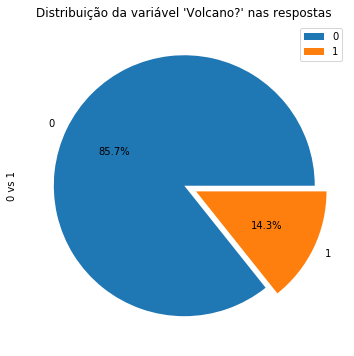

In [8]:
# grafico de pizza para ver como está dividida a base de dados
resp["Volcano?"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = False)
plt.ylabel('0 vs 1')
plt.legend(['0', '1'])
plt.title("Distribuição da variável 'Volcano?' nas respostas")
plt.show()

Podemos perceber que há 6 vezes mais imagens sem vulcão do que com vulcão. Logo, temos que o primeiro problema de classificação, cujo objetivo é classificar as imagens como as que têm e as que não têm vulcão, é um problema desbalanceado. Esse fato deve ser levado em questão ao fazermos a classificação. 

No segundo problema, os dados observados são as linhas do DataFrame `feat`para as quais a variável `Volcano?`é 1, e a variável resposta é a coluna do DataFrame `resp`. Assim, temos quatro classes nas respostas, que consistem nos tipos de vulcões, variável que codifica a incerteza sobre a existência de um vulcão nas imagens. Vamos ver como cada classe é distribuida para essa variável respostas:

In [9]:
# contando quantos dados temos de cada classe
resp[resp['Volcano?'] == 1]['Type'].value_counts()

4.0    362
3.0    346
2.0    187
1.0    105
Name: Type, dtype: int64

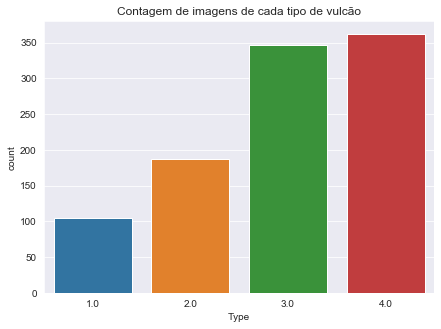

In [10]:
# histograma com os tipos no eixo x e numero de imagens de cada tipo no eixo y
sns.set_style(style="darkgrid")
plt.figure(figsize=(7,5))

sns.countplot(x=resp[resp['Volcano?'] == 1]['Type'])
plt.title("Contagem de imagens de cada tipo de vulcão")
plt.show()

Podemos perceber que as classes nesse problema também estão desbalanceadas: a classe com maior número de ocorências tem número de imagens no banco de dados mais do que 3 vezes maior do que a classe com menor número de ocorrências. 

Por fim, vamos analisar a distribuição das classes no terceiro problema. Para esse problema,  os dados observados são as linhas do DataFrame `feat` para as quais a variável `Volcano?` é 1, e a variável resposta é a coluna `Number Volcanoes` do DataFrame `resp`. A distribuição das classes desse problema é vista a seguir:

In [11]:
# contando quantos dados temos de cada classe
resp[resp['Volcano?'] == 1]['Number Volcanoes'].value_counts()

1.0    814
2.0    147
3.0     30
4.0      7
5.0      2
Name: Number Volcanoes, dtype: int64

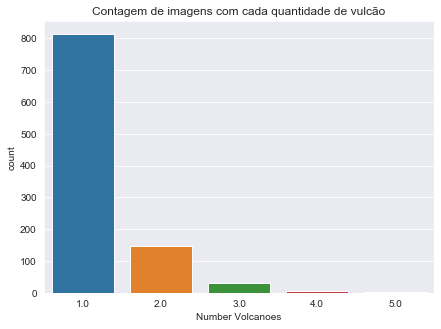

In [12]:
# histograma com os tipos no eixo x e numero de imagens de cada tipo no eixo y
sns.set_style(style="darkgrid")
plt.figure(figsize=(7,5))

sns.countplot(x=resp[resp['Volcano?'] == 1]['Number Volcanoes'])
plt.title("Contagem de imagens com cada quantidade de vulcão")
plt.show()

Percebe-se que as classes desse problema são altamente desbalanceadas: a classe que corresponde a um vulcão concentra mais de 80% de todos os dados da base considerada, enquanto existem classes em que há menos de 0.01% dos dados, a saber, as classes 4 e 5.

Assim, temos que os três problemas a serem tratados neste trabalho têm base de dados desbalanceada. Essa característica da base de dados deverá ser tratada com atenção ao fazermos a classificação em cada problema. 

### 3.3 Processamento de imagens
A base de dados com que estamos trabalhando contém 7000 imagens de tamanho $(110,110)$ que retratam as superfícies que podem ter ou não vulcões. Vamos observar alguns exemplos dessas imagens para entendermos como elas são:

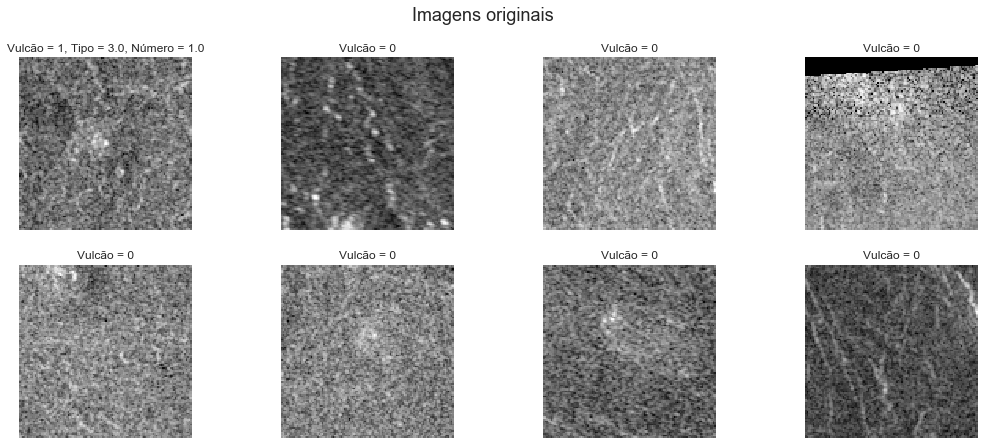

In [13]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(18, 7)
ind = 0

for ax in axs.flat:
    ax.imshow(images[ind], cmap = 'gray')
    ax.axis('off')
    v = resp["Volcano?"][ind]
    t = resp["Type"][ind]
    n = resp["Number Volcanoes"][ind]
    if v == 0:
        ax.set_title(f"Vulcão = {v}", fontsize = 12)
        ind += 1
    else:
        ax.set_title(f"Vulcão = {v}, Tipo = {t}, Número = {n}", fontsize = 12)
        ind += 1
        

plt.suptitle("Imagens originais", fontsize = 18)
plt.show()

Podemos ver que as imagens não são muito nítidas. Por isso, será feito o processamento das imagens, usando transformações para melhorar a visualização. 

A transformação escolhida para ser usada neste trabalho foi a reconstrução das imagens usando dilatação, por meio do método `reconstruction` do `sci-kit-image morphology`. Essa transformação nos possibilita encontrar pontos claros em uma imagem a partir da dilatação, que expande os valores máximos da imagem original até encontrar uma `mask`. Essa reconstrução é útil para encontrar picos que, no nosso caso, correspondem aos vulcões.

Vamos aplicar a transformação `reconstruction`com o método `dilation`em todas as imagens do nosso banco de dados:

In [14]:
# aplicando reconstrução com dilatação em todas as imagens, para que os picos (ou vulcões) fiquem mais nitidos
recs = []
for image in images:
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    rec = reconstruction(seed, mask, method='dilation')
    recs.append(rec)

Podemos visualizar novamente as imagens dos vulcões, agora após realizada a transformação nas fotos. Vemos a seguir as imagens transformadas:

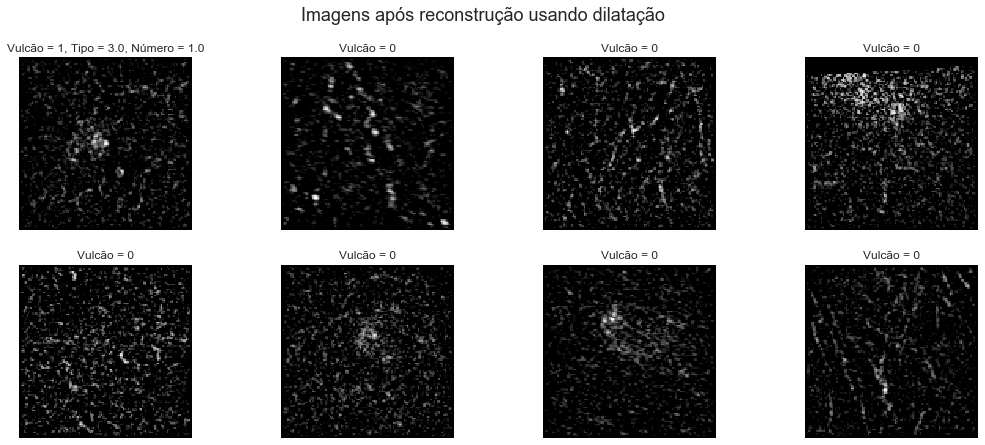

In [15]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(18, 7)
ind = 0

for ax in axs.flat:
    ax.imshow(images[ind] - recs[ind], cmap = 'gray')
    ax.axis('off')
    v = resp["Volcano?"][ind]
    t = resp["Type"][ind]
    n = resp["Number Volcanoes"][ind]
    if v == 0:
        ax.set_title(f"Vulcão = {v}", fontsize = 12)
        ind += 1
    else:
        ax.set_title(f"Vulcão = {v}, Tipo = {t}, Número = {n}", fontsize = 12)
        ind += 1
        
plt.suptitle("Imagens após reconstrução usando dilatação", fontsize = 18)
plt.show()

Podemos ver que a visualização das imagens melhorou consideravelmente após essa transformação! As imagens ficaram bem mais nítidas e mais esparsas após essa reconstrução. 

Feita essa transformação, vamos aplicar um método para descrever os atributos das imagens. O método escohido neste trabalho foi o `Histogram of oriented gradients (HOG)`. Essa trasformação foi escolhida por ser comum em problemas de detecção em imagens. A ideia do `HOG` é de, em vez de usar cada direção de gradiente individualmente de cada pixel de uma imagem, podemos agupar os pixels em células menores e, para cada célula, calculamos todas as direções dos gradientes e as agrupamos em uma quantidade dada de `orientation bins`. Somamos a magnitude dos gradientes em cada amostra, então gradientes maiores contribuem mais para o peso de seus `bins`, e efeitos de pequenas orientações aleatórias devido ao ruido são reduzidos. 

O `HOG`nos dá, então, a representação da orientação dominante de célula. Ao fazermos isso em todas as células, temos uma representação da estrutura da imagem. Isso faz com que as imagens fiquem mais esparsas, o que tornará mais viável fazer as classificações desejadas. Vamos, então, aplicar `HOG`em cima da reconstrução já realizada:

In [16]:
# aplicando hog em todas as imagens
# essa célula demora um pouco para rodar
hogs = []
hog_features = []
for i in range(len(recs)):
    fd, hog_image = hog(images[i] - recs[i], orientations=8, pixels_per_cell=(10, 10),
                    cells_per_block=(3,3), visualize=True)
    hogs.append(hog_image)
    hog_features.append(fd)

Podemos visualizar mais uma vez as imagens dos vulcões, agora após realizada a reconstrução e o `HOG`. Vemos a seguir as imagens transformadas:

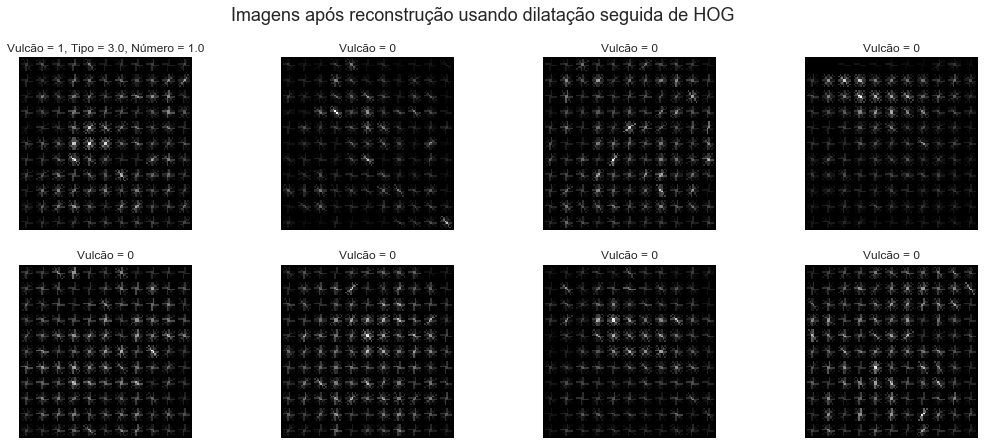

In [17]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(18, 7)
ind = 0

for ax in axs.flat:
    ax.imshow(hogs[ind], cmap = 'gray')
    ax.axis('off')
    v = resp["Volcano?"][ind]
    t = resp["Type"][ind]
    n = resp["Number Volcanoes"][ind]
    if v == 0:
        ax.set_title(f"Vulcão = {v}", fontsize = 12)
        ind += 1
    else:
        ax.set_title(f"Vulcão = {v}, Tipo = {t}, Número = {n}", fontsize = 12)
        ind += 1
        
plt.suptitle("Imagens após reconstrução usando dilatação seguida de HOG", fontsize = 18)
plt.show()

Vamos que as imagens de fato estão mais esparsas, o que torna mais viável que sejam resolvidos os problemas de classificação em questão. Assim, para resolver os problemas propostos no projeto, vamos usar os atributos após a reconstrução usando dilatação e o uso do `HOG`.

### 3.4 Problemas de classificação
O presente trabalho tem como objetivo resolver três problemas de classificação. São eles: 1) prever, a partir de uma imagem, se na foto há ou não um vulcão; 2) Prever, somente a partir das imagens que têm ao menos um vulcão, o tipo dele; 3) Prever, somente a partir das imagens que têm ao menos um vulcão, a quantidade de vulcões que há na imagem.

Feita a análise exploratória e pré-processamento das imagens, podemos finalmente resolver os problemas de classificação. Para resolver cada um dos problemas de classificação, vamos usar os atributos obtidos após aplicados reconstrução por dilatação e `HOG` nas imagens do banco de dados.

#### 3.4.1 Primeiro problema de classificação
Neste problema, desejamos prever, a partir de uma imagem, se ela contém ou não um vulcão. Devido ao que foi pedido no trabalho, consideraremos que falsos negativos são mais graves do que falsos positivos, logo deve-se penalizar mais os falsos negativos. 

Primeiramente, vamos criar um DataFrame $X$, que corresponde aos atributos das imagens após feitas as transformações nas figuras (reconstrução e `HOG`). Vamos também criar um $Y$, que corresponde à variável resposta do primeiro problema. Para esse problema, a variável resposta é a coluna `Volcano?`do DataFrame `resp`:

In [18]:
# criando o dataframe X e o y
X = np.array(hog_features)
X = pd.DataFrame(X)
y = resp["Volcano?"]

Para resolver o problema de classificação em questão, vamos dividir as observações em conjuntos de treino e teste. Vamos usar o parâmetro  `stratify`, que faz com que a separação entre treino e teste tenha a proporção de valores 0 e 1 igual à proporção de 0 e 1 existente na coluna `Volcano?`do DataFrame `resp`. Isso será usado porque, como foi visto anteriormente, o conjunto de dados é desbalanceado, e não queremos que a separação de treino e teste elimine ou reduza muito uma classe dos conjuntos de treino ou teste. Além disso, vamos usar o parâmetro  `random_state` para garantir reprodutibilidade do código. Vamos considerar a separação entre treino e teste de todo o conjunto de dados, sem nenhuma alteração.

In [19]:
# separar em treino-teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

Para esse problema, será usado o Support Vector Classifier (SVC). Como o primeiro problema trata-se de uma questão de reconhecer um objeto nas imagens, esse classificador paraceu adequado e comumente usado nesse tipo de problema. 

Para saber que parâmetros usar no classificador, vamos usar o método `GridSearchCV`. Foram testados os kernel's linear, poly e rbf, porém os testes com poly e rbf demoraram muito para rodar o `GridSearchCV`. Assim, decidi usar apenas o kernel linear, que produziu bons resultados e não foi tão lento. 

Portanto, vamos primeiro usar o `GridSearchCV`, que realiza uma procura sob os valores especificados do parâmetro de regularização C do SVC, e nos indica com qual dos parâmetros o classificador teve melhor desempenho. Para medir o desempenho com os diferentes parâmetros, foi escolhido usar acurácia. A seguir vamos, então, fazer `GridSearchCV` para saber com qual dos parâmetros da lista de C o classificador usando kernel linear tem melhor desempenho:

In [20]:
%%time
param_lin = [{'C': [0.01, 0.1, 1, 10, 20, 50]}] 

svm_lin_CV = GridSearchCV(SVC(kernel = 'linear', probability = True), param_grid = param_lin, cv = 5, scoring = 'accuracy', verbose = 4, n_jobs = -1)

svm_lin_CV.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 22min 32s


GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 20, 50]}], scoring='accuracy',
             verbose=4)

Vamos salvar o melhor estimador encontrado pelo `GridSearchCV`, e vamos usá-lo para fazer o ajuste aos nossos dados:

In [21]:
%%time
# classificação usando o melhor classificador (encontrado pelo GridSearchCV)
clf_lin = svm_lin_CV.best_estimator_
clf_lin.fit(X_train, y_train)

y_pred_lin = clf_lin.predict(X_test)

Wall time: 1min 27s


Vamos avaliar o resultado obtido ao classificar o conjunto de dados em questão. Vamos ver a matriz de confusão obtida:

In [22]:
CM_lin = metrics.confusion_matrix(y_test, y_pred_lin)

In [23]:
CM_lin

array([[1479,   21],
       [  58,  192]], dtype=int64)

Nesse caso, estamos usando a probabilidade de corte padrão da classificação, igual a $0.5$. Vamos aferir as métricas para o classificador nesse caso, usando Acurácia, Precisão, Recall ("taxa de verdadeiros positivos"), F1 (média entre precisão e recall), AUC_ROC (área abaixo da curva ROC), usando só uma divisão de treino e teste.

In [24]:
# sem usar k-cv (só uma observação da variavel aleatoria)
# metricas usando p = 0.5 
models_correlation = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test, y_pred_lin)],
    'Precision'   : [precision_score(y_test, y_pred_lin)],
    'Recall'      : [recall_score(y_test, y_pred_lin)],
    'F1_score'    : [f1_score(y_test, y_pred_lin)],
    'AUC_ROC'     : [roc_auc_score(y_test, y_pred_lin)],
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])


models_correlation.rename(index = {0: "SVC"}, inplace = True)
print ("Usando probabilidade de corte p = 0.5: ")
models_correlation

Usando probabilidade de corte p = 0.5: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
SVC,0.954857,0.901408,0.768,0.829374,0.877


Temos que, com a probabilidade de corte padrão, as métricas encontradas já são bem altas. No entanto, segue da proposta do trabalho que devemos tomar mais cuidado com falsos negativos do que falsos positivos. Assim, devemos buscar aumentar o Recall.

Temos que, na matriz de confusão, a entrada $CM_{1,1}$ indica verdadeiro negativo, $CM_{1,1}$ verdadeiro negativo, $CM_{1,2}$ falso positivo (erro tipo I), $CM_{2,1}$ falso negativo (erro tipo II) e $CM_{2,2}$ verdadeiro positivo. Pela proposta do trabalho, é dito que devemos considerar falso negativo como mais grave do que falso positivo. Assim, devemos buscar diminuir a entrada $CM_{2,1}$, e aumentar o Recall. Além disso, como já foi visto na análise exploratória dos dados, as classes nesse problema estão desbalanceadas.

Uma forma de penalizar mais os falso negativos do que os falso positivos e, ao mesmo tempo, fazer a classificação com o conjunto de dados desbalanceado sem alterá-lo e termos métricas satisfatórias, é ajustando a forma que fazemos a classificação, alterando a probabilidade de corte na classificação.

Primeiro, vamos guardar todas as probabilidades de predição, para cada classe:

In [25]:
# guardando as probabilidades de predição pra cada classe
y_pred_lin_proba = clf_lin.predict_proba(X_test)

Para evitar falso negativo, devemos diminuir a probabilidade de corte, para um valor menor do que $0.5$. Foi escolhido usar a probabilidade de corte $p0 = 0.143$, que corresponde à proporção de dados da classe positiva no conjunto de dados completo

In [26]:
# nova probabilidade de corte:
p0 = 0.143

Agora, vamos mudar a probabilidade de corte. Vamos aceitar a classe positiva quando a probabillidade prevista para essa classe for maior do que p0 e aceitar a negativa caso contrário. Essa probabilidade é aproximadamente a proporção de dados da classe positiva no conjunto de dados. Poderíamos considerar outras probabilidades de corte também. 

Podemos, então, criar os novos vetores de predições, considerando a nova probabilidade de corte p0. Em seguida, podemos também computar as matrizes de confusão para cada classificador.

In [27]:
# mudando o y da predição, considerando o ponto de corte em p0
# depois, fazemos a nova matriz de confusão
y_pred_lin_p0 = 1*(y_pred_lin_proba[:,1] > p0)
CM_lin_p0 = sklm.confusion_matrix(y_test, y_pred_lin_p0)

Vamos ver a nova matriz de confusão, depois da mudança no ponto de corte da classificação.

In [28]:
CM_lin_p0

array([[1396,  104],
       [  29,  221]], dtype=int64)

Analisando a segunda linha da matriz, vemos que, agora, como queríamos, o número de falsos negativos diminuiu bastante comparado ao observado com probabilidade de corte 0.5. Temos que a classificação agora acerta mais na classe positiva, o que era o nosso objetivo.

Comparando com a matriz de confusão obtida anteriormente, com ponto de corte 0.5, temos agora que o classificador classifica menos verdadeiros negativos do que antes, e tem mais falso positivo (isso é visto analisando a primeira linha das matrizes). Isso se dá porque, quando mudamos a probabilidade de corte pra classe positiva para $p0 \approx 0.14 < 0.5$, assumimos que os erros de falso positivo são menos graves do que os erros falso negativo (erro tipo I é menos grave que erro tipo II). Assim, ao diminuir a probabilidade de corte para p0, aceitamos mais dados na classe 1 e assumimos que é menos grave dizer que uma superfície tem vulcão, quando na verdade não tem (falso positivo) do que dizer que um uma superfície não tem vulcão, quando na verdade tem (falso negativo).

Vamos fazer o gráfico da curva ROC para o classificador, marcando de vermelho o ponto que corresponde à classificação usando p0 e de verde o ponto que corresponde à classificação com ponto de corte 0.5.

In [29]:
# fazendo a curva ROC pra cada classificador
fpr_lin_p0, tpr_lin_p0, _ = sklm.roc_curve(y_test, y_pred_lin_proba[:,1])

In [30]:
# informações sobre os dados
Pop = np.size(y_test)
N = np.size(np.where(y_test == 0))
P = np.size(np.where(y_test == 1))

# usando ponto de corte p0
# calculos dos falsos positivos 
FP_p0 = CM_lin_p0[0, 1]
# calculo da taxa de falsos positivos
FPR_p0 = FP_p0/N 
# calculo dos verdadeiros positivos
VP_p0 = CM_lin_p0[1, 1]
# calculo da taxa de verdadeiros positivos
TPR_p0 = VP_p0/P 

# usando ponto de corte 0.5
# calculos dos falsos positivos 
FP = CM_lin[0, 1]
# calculo da taxa de falsos positivos
FPR = FP/N 
# calculo dos verdadeiros positivos
VP = CM_lin[1, 1]
# calculo da taxa de verdadeiros positivos
TPR = VP/P 

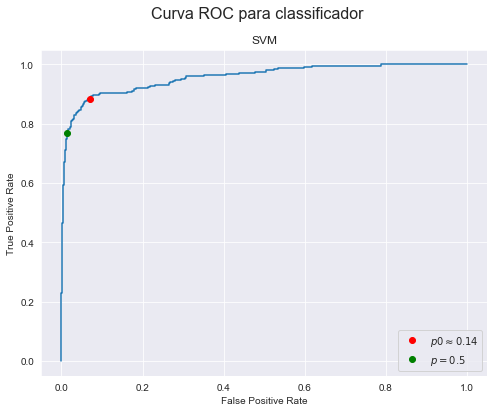

In [31]:
# fazendo o grafico
plt.figure(figsize = (8,6))
plt.plot(fpr_lin_p0, tpr_lin_p0)
plt.plot(FPR_p0, TPR_p0, 'ro', label = r'$p0 \approx 0.14$')
plt.plot(FPR, TPR, 'go', label = '$p = 0.5$')
plt.title('SVM')
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.legend()
plt.suptitle("Curva ROC para classificador", fontsize = 16)
plt.show()

Podemos ver, analisando a curva ROC do classificador, que o resultado obtido ao usarmos $p0 \approx 0.14$ é melhor do que aquele obtido ao usarmos a probabilidade de corte padrão $p = 0.5$. Isso é claro de ver no gráfico pois o ponto vermelho (que corresponde à classificação com $p0 \approx 0.14$) é  mais próximo do ponto ideal $(0,1)$ do que o ponto verde (que corresponde à classificação usando p = 0.5). 

Assim, a classificação mudando ponto de corte para $p0$ parece ter melhorado a classificação. Vamos aferir as métricas para ver se, de fato, a classificação melhorou.

In [32]:
# sem usar k-cv (só uma observação da variavel aleatoria)
# metricas usando p0 
models_correlation_p0 = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test, y_pred_lin_p0)],
    'Precision'   : [precision_score(y_test, y_pred_lin_p0)],
    'Recall'      : [recall_score(y_test, y_pred_lin_p0)],
    'F1_score'    : [f1_score(y_test, y_pred_lin_p0)],
    'AUC_ROC'     : [roc_auc_score(y_test, y_pred_lin_p0)],
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])


models_correlation_p0.rename(index = {0: "SVC"}, inplace = True)
print ("Usando probabilidade de corte p0: ")
models_correlation_p0

Usando probabilidade de corte p0: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
SVC,0.924,0.68,0.884,0.768696,0.907333


Vamos comparar com as métricas usando $p = 0.5$, calculadas anteriormente

In [33]:
# metricas usando p=0.5, calculadas anteriormente
print ("Usando probabilidade de corte 0.5: ")
models_correlation

Usando probabilidade de corte 0.5: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
SVC,0.954857,0.901408,0.768,0.829374,0.877


Comparando os resultados usando como probabilidade de corte 0.5 e $p0 \approx 0.14$, vemos que o Recall (taxa de verdadeiros positivos) aumenta significativamente ao usarmos p0. Logo, para o nosso caso, o classificador usando a probabilidade de corte p0 é mais adequado, já que buscamos um classificador com bom desempenho no Recall, dado que consideramos falso negativo muito grave no nosso problema.

Além disso, temos que, ao usar p0, a área abaixo da curva ROC aumenta, o que é um indicativo de que a classificação melhorou. Temos que a precisão diminui um pouco quando mudamos a probabilidade de corte para p0, o que já era esperado, já que assumimos que erros de falso positivo são menos graves do que os de falso negativo. Como a precisão diminui, o F1 também diminui um pouco. Além disso, a acurácia também abaixa um pouco ao usarmos probabilidade de corte p0.

Como o classificador usando probabilidade de corte p0 penaliza mais os falso negativos, aumentando o Recall, temos que ele é o mais adequado para o nosso problema. 

#### 3.4.2 Segundo problema de classificação
Neste problema, desejamos prever, a partir de uma imagem com vulcão, qual é o tipo dele. Para esse problema, devemos considerar como dados observados as linhas do DataFrame `feat` para os quais a variável `Volcano?`é 1, e a variável resposta é a coluna ``Type`` do DataFrame ``resp``.

Primeiro, vamos criar um DataFrame `feat2`, que corresponde aos atributos das imagens após feitas as transformações nas figuras (reconstrução e `HOG`), apenas para as imagens que contém vulcão. Vamos também criar um `resp2`, que corresponde às variáveis respostas para os dados que têm vulcão.

In [34]:
feat2 = feat[resp['Volcano?'] == 1]
resp2 = resp[resp['Volcano?'] == 1]

Vamos, agora, ver os índices das imagens que têm vulcão. Usando os índices, podemos guardar os vetores que correspondem às imagens após a reconstrução por dilatação e após `HOG`:

In [35]:
# indices de onde tem volcano? = 1
indices2 = resp2.index
# reconstrução após dilatação para as imagens com vulcão
recs2 = [recs[i] for i in indices2]
# transformação por HOG para as imagens com vulcão
hogs2 = [hogs[i] for i in indices2]
hog_features2  = [hog_features[i] for i in indices2]

Para esse poblema, vamos criar um DataFrame $X2$, que corresponde aos atributos das imagens após feitas as transformações nas figuras (reconstrução e `HOG`), para as imagens com vulcão. Vamos também criar um $Y2$, que corresponde à variável resposta do segundo problema. Para esse problema, a variável resposta é a coluna `Type`do DataFrame `resp`, para as linhas em que há vulcão:

In [36]:
y2 = resp2["Type"]
X2 = np.array(hog_features2)
X2 = pd.DataFrame(X2)

Vamos dividir as observações em conjuntos de treino e teste. Como vimos que o conjunto de dados nesse problema é desbalanceado, vamos usar o parâmetro `stratify`, que faz com que a separação entre treino e teste respeite as proporções de cada classe existente em `y2`.

In [37]:
# separar em treino-teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y2, test_size = 0.25, random_state=42)
y_train2 = y_train2.ravel()
y_test2 = y_test2.ravel()

Para esse problema, será usado o Support Vector Classifier (SVC) e métodos baseados em árvores. Vamos primeiro fazer a classificação usando SVC. 

Para saber que parâmetros usar no classificador SVC, vamos usar o método `GridSearchCV` que realiza uma procura sob os valores especificados dos parâmetros do SVC, e nos indica com qual dos parâmetros o classificador teve melhor desempenho. Para esse problema, vamos fazer o `GridSearchCV` para o kernel linear e para o radial, assim como os seus respectivos parâmetros, procurando qual classificador tem melhor desempenho. 

Como as classes desse problema são desbalanceadas, foi tomado o parâmetro `class_weights = balanced`, que faz com que o modelo automaticamente assuma pesos para cada classe de forma inversamente proporcional à frequência de cada classe. 

In [38]:
# parametros pro GridSearchCV
pipe_parameters = [
    {
     'C':  [0.001, 0.01, 0.1, 1], 
     'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
     'kernel': ['rbf'],
    'class_weight': ['balanced']},
    {
     'C':  [0.001, 0.01, 0.1, 1],
     'kernel': ['linear'],
    'class_weight': ['balanced']}
]

Podemos, então, fazer o `GridSearchCV`:

In [39]:
%%time
grid = GridSearchCV(SVC(), pipe_parameters, cv = 5, scoring = 'accuracy', verbose = 4)
grid.fit(X_train2, y_train2)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   2.8s
[CV 2/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   2.5s
[CV 3/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   2.3s
[CV 4/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   2.7s
[CV 5/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   2.2s
[CV 1/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV 2/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.5s
[CV 3/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV 4/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.4s
[CV 5/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.5s
[CV 1/5] END C=0.001, class_weight=balanced

[CV 5/5] END C=1, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   2.2s
[CV 1/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV 2/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.2s
[CV 3/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV 4/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV 5/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV 1/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   2.4s
[CV 2/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   2.5s
[CV 3/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   2.8s
[CV 4/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.2s
[CV 5/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.4s
[CV 1/5] END C=1, class_weight=balanced, gamma=0.01, kernel=

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1],
                          'class_weight': ['balanced'],
                          'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                          'kernel': ['rbf']},
                         {'C': [0.001, 0.01, 0.1, 1],
                          'class_weight': ['balanced'], 'kernel': ['linear']}],
             scoring='accuracy', verbose=4)

Podemos salvar o classificador com melhor desempenho encontrado pelo `GridSearchCV`, e usá-lo para fazer a classificação:

In [40]:
# salvando classificador com melhor desempenho
clf_lin2 = grid.best_estimator_
# classificação
clf_lin2.fit(X_train2, y_train2)
y_pred_2 = clf_lin2.predict(X_test2)

Vamos avaliar as métricas obtidas usando o classificador em questão SVC. Como temos um problema multiclasse, precisamos reconsiderar as métricas precision, recall e f1. Foi escolhido avaliar a média ponderada dessas métricas, usando `average = weighted`, porque o conjunto de dados é desbalanceado:

In [41]:
# para as métricas, ver https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
models_correlation2 = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test2, y_pred_2)],
    'Precision'   : [precision_score(y_test2, y_pred_2, average = 'weighted')],
    'Recall'      : [recall_score(y_test2, y_pred_2, average = 'weighted')],
    'F1_score'    : [f1_score(y_test2, y_pred_2, average = 'weighted')]
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score'])


models_correlation2.rename(index = {0: "SVC"}, inplace = True)
print ("Resultados das métricas do segundo problema, usando SVC: ")
models_correlation2

Resultados das métricas do segundo problema, usando SVC: 


,Accuracy,Precision,Recall,F1_score
SVC,0.532,0.543348,0.532,0.50091


Temos que o desempenho do classificador nesse problema é bem inferior ao do obtido no primeiro problema. No entanto, isso pode estar acontecendo já que esse é um problema que, além de altamente desbalanceado, é multiclasse, o que torna mais difícil a obtenção de métricas altas.  

Podemos fazer a classificação usando métodos baseados em árvores, para ver se as métricas obtidas melhoram. Neste trabalho, foi escolhido fazer essa classificação usando Decision Tree Classifier.

Para saber que parâmetros usar no classificador Decision Tree, vamos usar o método `GridSearchCV` , para saber que valores dos parâmetros `criterion`, que mede a qualidade de uma divisão, e `max_depth`, que mexe a profundidade máxima da árvore, atingem o melhor desempenho na classificação.  

Novamente, foi tomado o parâmetro `class_weights = balanced`, devido ao desbalanço dos dados

In [42]:
# parametros pro GridSearchCV
pipe_parameters2 = [{'criterion': ['entropy', 'gini'], 'max_depth' : [5,10, 50],'class_weight' : ['balanced']}]

In [43]:
%%time
grid2 = GridSearchCV(DecisionTreeClassifier() , pipe_parameters2, cv = 5, scoring = 'accuracy', verbose = 4)
grid2.fit(X_train2, y_train2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=5; total time=   4.4s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=5; total time=   4.0s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=5; total time=   4.2s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=5; total time=   4.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=5; total time=   3.6s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=10; total time=   5.3s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=10; total time=   5.1s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=10; total time=   5.1s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=10; total time=   5.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=10; total time=   5.0s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 10, 50]}],
             scoring='accuracy', verbose=4)

Salvando o classificador com melhor desempenho encontrado pelo `GridSearchCV`, e fazendo a classificação com ele, temos:

In [44]:
# salvando classificador com melhor desempenho
clf_tree2 = grid2.best_estimator_
# classificação
clf_tree2.fit(X_train2, y_train2)
y_pred_tree2 = clf_tree2.predict(X_test2)

Podemos avaliar as métricas obtidas usando o classificador obtido de árvore de decisão:

In [45]:
# para as métricas, ver https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
models_correlation2b = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test2, y_pred_tree2)],
    'Precision'   : [precision_score(y_test2, y_pred_tree2, average = 'weighted')],
    'Recall'      : [recall_score(y_test2, y_pred_tree2, average = 'weighted')],
    'F1_score'    : [f1_score(y_test2, y_pred_tree2, average = 'weighted')]
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score'])


models_correlation2b.rename(index = {0: "Decision Tree"}, inplace = True)
print ("Resultados das métricas do segundo problema, usando árvore de decisão: ")
models_correlation2b

Resultados das métricas do segundo problema, usando árvore de decisão: 


,Accuracy,Precision,Recall,F1_score
Decision Tree,0.392,0.392315,0.392,0.390703


Vamos comparar com as métricas obtidas usando SVC:

In [46]:
print ("Resultados das métricas do segundo problema, usando SVC: ")
models_correlation2

Resultados das métricas do segundo problema, usando SVC: 


,Accuracy,Precision,Recall,F1_score
SVC,0.532,0.543348,0.532,0.50091


Temos que as métricas obtidas usando Support Vector Classifier, com os parâmetros encontrados pelo `GridSearchCV`, são as melhores para esse problema. Tanto as métricas usando SVC quanto as usando árvore de decisão são baixas. Como é um problema desbalanceado multiclasse, é mais difícil obter métricas altas. Logo, as métricas obtidas usando SVC otimizado com `GridSearchCV`, apesar de não serem muito altas, são aceitáveis para o nosso problema, considerando a o rau de complexidade dele, em comparação com o primeiro problema.

#### 3.4.3 Terceiro problema de classificação
Neste problema, desejamos prever, a partir de uma imagem com vulcão, qual quantos vulcões existem na foto. Para esse problema, devemos considerar como dados observados as linhas do DataFrame `feat` para os quais a variável `Volcano?`é 1, e a variável resposta é a coluna ``Number Volcanoes`` do DataFrame ``resp``.

Temos que os dados observados são os mesmos do segundo problema, por isso podemos usar o mesmo vetor de atributos que o usado no problema anterior (`hog_features2`), que corresponde aos atributos das imagens após feitas as transformações nas figuras (reconstrução e `HOG`), apenas para as imagens que contém vulcão. Usando `resp2`, que corresponde ao DataFrame das variáveis respostas para os dados que têm vulcão, vamos criar `y3`, que corresponde à variável resposta do terceiro problema, que indica quantos vulcões existem nas imagens que têm vulcão. Obtemos `y3` a partir da coluna `Number Volcanoes`do DataFrame `resp2`.

In [47]:
y3 = resp2["Number Volcanoes"]
X3 = np.array(hog_features2)
X3 = pd.DataFrame(X3)

Vamos dividir as observações em conjuntos de treino e teste. Como o conjunto de dados nesse problema é desbalanceado, vamos usar o parâmetro `stratify`, que faz com que a separação entre treino e teste mantenha as proporções de cada classe existente em `y3`.

In [48]:
# separar em treino-teste
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify = y3, test_size = 0.25, random_state=42)
y_train3 = y_train3.ravel()
y_test3 = y_test3.ravel()

Neste problema, será usado o Support Vector Classifier (SVC). 

Vamos usar o método `GridSearchCV`, que realiza uma procura sob os valores especificados dos parâmetros fornecidos para o SVC, e nos indica com quais dos parâmetros o classificador teve melhor desempenho. Para esse problema, vamos fazer o `GridSearchCV` para o kernel linear e para o radial, assim como os seus respectivos parâmetros. 

Assim como no problema anterior, dado o desbalanço entre as classes, foi tomado o parâmetro `class_weights = balanced`, que faz com que o modelo automaticamente assuma pesos para cada classe de forma inversamente proporcional à frequência de cada classe nos dados de input.

Vamos, então, definir os parâmetros que serão usados no `GridSearchCV`:

In [49]:
pipe_parameters3 = [
    {
     'C':  [0.001, 0.01, 0.1, 1], 
     'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
     'kernel': ['rbf'],
    'class_weight': ['balanced']},
    {
     'C':  [0.001, 0.01, 0.1, 1, 5],
     'kernel': ['linear'],
    'class_weight': ['balanced']}
]

Podemos, então, fazer o `GridSearchCV` com os parâmetros especificados acima:

In [50]:
%%time
grid3 = GridSearchCV(SVC(), pipe_parameters3, cv = 5, scoring = 'accuracy', verbose = 4)
grid3.fit(X_train3, y_train3)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


C:\Users\biafa\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[CV 1/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   3.6s
[CV 2/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   3.9s
[CV 3/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   4.3s
[CV 4/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   3.9s
[CV 5/5] END C=0.001, class_weight=balanced, gamma=1e-05, kernel=rbf; total time=   3.4s
[CV 1/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   4.0s
[CV 2/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   4.2s
[CV 3/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   3.8s
[CV 4/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   4.1s
[CV 5/5] END C=0.001, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   3.3s
[CV 1/5] END C=0.001, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   4.0s
[CV 2/5] END C=0

[CV 1/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   4.1s
[CV 2/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   4.0s
[CV 3/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   4.1s
[CV 4/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   3.9s
[CV 5/5] END C=1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   3.4s
[CV 1/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.8s
[CV 2/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.6s
[CV 3/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.6s
[CV 4/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   4.0s
[CV 5/5] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.2s
[CV 1/5] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   2.9s
[CV 2/5] END C=1, class_weight=balanced, gamma=0.01, kernel=r

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1],
                          'class_weight': ['balanced'],
                          'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                          'kernel': ['rbf']},
                         {'C': [0.001, 0.01, 0.1, 1, 5],
                          'class_weight': ['balanced'], 'kernel': ['linear']}],
             scoring='accuracy', verbose=4)

Podemos salvar o classificador com melhor desempenho segundo o `GridSearchCV`:

In [51]:
# classificador com melhor desempenho, obtido pelo GridSearchCV
clf_3 = grid3.best_estimator_

Usando o classificador com melhor desempenho obtido pelo `GridSearchCV`, podemos fazer a classificação:

In [52]:
# classificação usando o melhor classificador, obtido pelo GridSearchCV
clf_3.fit(X_train3, y_train3)
y_pred_3 = clf_3.predict(X_test3)

Podemos analisar a matriz de confusão obtida nesse caso, que será dada a seguir:


In [53]:
CM_3 = metrics.confusion_matrix(y_test3, y_pred_3)
CM_3

array([[201,   2,   0,   0,   0],
       [ 33,   4,   0,   0,   0],
       [  7,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0]], dtype=int64)

Vemos que a classificação só acerta nas classes 1 e 2. Isso ocorre porque essas classes concentram quase o número todo de dados totais: 

In [54]:
# base super desbalanceada!!
y3.value_counts()

1.0    814
2.0    147
3.0     30
4.0      7
5.0      2
Name: Number Volcanoes, dtype: int64

Assim, a classificação acerta somente nas classes 1 e 2, que concentram 961 dos 1000 dados totais considerados nesse problema. As demais classes, por terem número de observações muito menores, viram como outliers para a nossa classificação.

Por fim, podemos aferir as métricas obtidas para esse classificador para esse problema:

In [55]:
models_correlation3 = pd.DataFrame({
    'Accuracy'    : [accuracy_score(y_test3, y_pred_3)],
    'Precision'   : [precision_score(y_test3, y_pred_3, average = 'weighted')],
    'Recall'      : [recall_score(y_test3, y_pred_3, average = 'weighted')],
    'F1_score'    : [f1_score(y_test3, y_pred_3, average = 'weighted')]
    }, columns = ['Accuracy', 'Precision', 'Recall', 'F1_score'])


models_correlation3.rename(index = {0: "SVC"}, inplace = True)
print ("Resultados das métricas do terceiro problema, usando SVC: ")
models_correlation3

Resultados das métricas do terceiro problema, usando SVC: 


C:\Users\biafa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1_score
SVC,0.82,0.767568,0.82,0.75779


Temos que as métricas para o classificador obtido pelo `GridSearchCV` são bem boas e altas, apesar de o classificador errar sempre nas classes 3,4 e 5. Os resultados são bons, apesar de só acertarmos nas classes 1 e 2 porque essas classes concentram a maior parte dos dados.

## 4. Discussão e resultados
Neste trabalho, foram usadas 7000 imagens de superfícies, assim como informações acerca de cada imagem, para resolver três problemas de classificação. 

O primeiro problema teve como objetivo prever, a partir da imagem, se ela contém ou não um vulcão. Para resolver esse problema, foi usado o classificador Support Vector Classifier com kernel linear, e foi obtido o parâmetro de regularização C a partir do `GridSearchCV`. Usando o classificador com melhor desempenho obtido por meio do `GridSearchCV`, foi feita a classificação usando o ponto de corte padrão igual a 0.5. As métricas aferidas dessa classificação seguem abaixo:

In [56]:
print ("Usando SVC e probabilidade de corte p = 0.5: ")
models_correlation

Usando SVC e probabilidade de corte p = 0.5: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
SVC,0.954857,0.901408,0.768,0.829374,0.877


Temos que, para o problema em questão, dizer que não existe um vulcão na imagem quando na verdade existe é mais grave do que dizer que existe vulcão quando na verdade não existe (ou seja, erro tipo I é menos grave do que erro tipo II). Então, para minimizar o falso negativo e ter métricas coerentes para o conjunto de dados, que é desbalanceado, podeos diminuir a probabilidade de corte da classificação. 

Foi escolhido diminuir a probabilidade de corte para $p_0 \approx 0.143$, que é aproximadamente a proporção de dados da classe positiva no conjuunto de dados. Diminuir a probabilidade de corte para $p_0$ implica em aceitar mais dados na classe 1, o que equivale a dizer que falso positivo é menos grave do que falso negativo, como desejado. 

Usando a probabilidade de corte $p_0 \approx 0.143$, as métricas passam a ser as seguintes:

In [57]:
print ("Usando probabilidade de corte p0: ")
models_correlation_p0

Usando probabilidade de corte p0: 


,Accuracy,Precision,Recall,F1_score,AUC_ROC
SVC,0.924,0.68,0.884,0.768696,0.907333


Temos que, usando SVC com kernel linear e parâmetro de regularização obtido por `GridSearchCV`, os resultados do problema ficam bastante satisfatórios. Além disso, diminuindo a probabilidade de corte da classificação para $p_0 \approx 0.143$, as métricas continuam altas e o Recall aumenta, o que era o desejado, para diminuir a ocorrência de falso negativo.

O segundo problema trata-se de prever, a partir das imagens que contém ao menos um vulcão, o tipo dele, ou seja, a variável que codifica a incerteza sobre a existência de vulcão na imagem. Pra esse problema, foram usados os classificadores SVC e Decision Tree Classifier, e os parâmetros dos classificadores foram obtidos por meio do `GridSearchCV`. As métricas obtidas para esse problema foram as seguintes:

In [58]:
print ("Resultados das métricas do segundo problema, usando SVC: ")
models_correlation2

Resultados das métricas do segundo problema, usando SVC: 


,Accuracy,Precision,Recall,F1_score
SVC,0.532,0.543348,0.532,0.50091


In [59]:
print ("Resultados das métricas do segundo problema, usando Decision Tree Classifier: ")
models_correlation2b

Resultados das métricas do segundo problema, usando Decision Tree Classifier: 


,Accuracy,Precision,Recall,F1_score
Decision Tree,0.392,0.392315,0.392,0.390703


Temos que as métricas obtidas nesse problema foram mais baixas do que nos demais problemas, mas isso pode se dar porque esse problema é multiclasse e altamente desbalanceado. Os melhores resultados foram obtidos usando SVC. 

Por fim, o terceiro problema consiste em prever, somente a partir das imagens que têm ao menos um vulcão, quantos vulcões há na imagem. Para esse problema, foi usado o classificador SVC, e foi usado `GridSearchCV` com os kernel's linear e rbf, com seus respectivos parâmetros. 

Foi feita a classificação usando o classificador com melhor desempenho, obtido pelo `GridSearchCV`, e os resultados obtidos foram os seguintes:

In [60]:
print ("Resultados das métricas do terceiro problema, usando SVC: ")
models_correlation3

Resultados das métricas do terceiro problema, usando SVC: 


,Accuracy,Precision,Recall,F1_score
SVC,0.82,0.767568,0.82,0.75779


As métricas obtidas para esse problema, usando SVC, foram altas e satisfatórias, apesar de o classificador obtido só acertar nas classes 1 e 2, que concentram mais de 96% dos dados totais.

## 5. Conclusão
Neste trabalho, foram resolvidos três problemas, a saber: 1) prever, a partir de uma imagem, se na foto há ou não um vulcão; 2) Prever, somente a partir das imagens que têm ao menos um vulcão, o tipo dele; 3) Prever, somente a partir das imagens que têm ao menos um vulcão, a quantidade de vulcões que há na imagem. Para isso, foi usada uma base de dados que reune 7000 imagens de tamanho $(110,110)$, que retratam superfícies. 

Foram usados os classificadores Support Vector Classifier e Decision Tree Classifier, e as métricas foram aferidas usando validação cruzada. Para o contexto dos problemas, consideramos que dizer que não existe um vulcão na imagem quando na verdade existe é mais grave do que cometer o erro contrário. 

Os resultados para os rês problemas foram satisfatórios, sendo o primeiro problema aquele que atingiu maiores valores nas métricas e o segundo problema, o que atingiu as menores. 

No futuro, um projeto interessante pode ser testar outros classificadores, como K-neighbors Classifier, Bagging Classifier e Random Forest Classifier. Além disso, pode ser interessante comparar o desempenho de redes neurais convolucionais com os classificadores usados nos três problemas. A fim de melhorar a classificação no terceiro problema, pode ser interessante também agrupar as classes 3,4,5 em uma classe "mais do que dois vulcões", para ver se o classificador passa a acertar não apenas nas classes 1 e 2.

## 6. Referências

- Notas de aula, slides e códigos da disciplina Aprendizagem de Máquina I - 2020/02


- Aprendizado de Máquina: Uma Abordagem Estatística - Rafael Izbicki & Tiago Mendonça dos Santos


- An Introduction to Statistical Learning - G. James, D. Witten, T. Hastie & R. Tibshirani


- Sites usados como referência:

    - https://customers.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/

    - https://rpubs.com/Sharon_1684/454441

    - https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

    - https://www.kaggle.com/halien/simple-image-classifer-with-svm

    - https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html

    - https://stackoverflow.com/questions/36677620/image-classification-using-svm-python